In [601]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [602]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('../data/kidney_disease_ckd.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,90.0,160.0,1.017,0.0,3.0,normal,normal,not present,not present,...,49.0,6745.0,3.0,no,no,yes,poor,yes,yes,notckd
1,1,57.0,131.0,1.016,5.0,5.0,normal,normal,not present,present,...,43.0,7594.0,4.5,no,no,yes,good,no,no,notckd
2,2,34.0,158.0,1.017,3.0,4.0,abnormal,normal,present,not present,...,37.0,10103.0,5.0,no,no,yes,poor,yes,no,notckd
3,3,35.0,106.0,1.023,0.0,2.0,normal,abnormal,present,present,...,48.0,4794.0,3.5,yes,yes,no,good,no,yes,notckd
4,4,16.0,155.0,1.024,0.0,3.0,abnormal,normal,not present,not present,...,28.0,7693.0,3.2,yes,no,no,poor,yes,yes,notckd


In [604]:
df['classification'].value_counts()
df['classification'].value_counts(normalize=True)

classification
ckd       0.570488
notckd    0.429512
Name: proportion, dtype: float64

In [605]:
df = df.drop('id', axis=1)

In [606]:
df['classification'] = df['classification'].str.strip()
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [607]:
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.replace('\t', '')

In [608]:
df = df.replace(['?', '\t?', ' ?'], np.nan)

In [609]:
df['classification'] = df['classification'].astype(str).str.lower()
df['classification'] = df['classification'].str.strip()
df['classification'] = df['classification'].str.replace('\t', '', regex=False)

print(df['classification'].unique())

valid_classes = ['ckd', 'notckd']
df = df[df['classification'].isin(valid_classes)].copy()

label_map = {'notckd': 0, 'ckd': 1}
df['classification'] = df['classification'].map(label_map).astype(int)

print("Giá trị nhãn sau khi mã hóa:", df['classification'].unique())


['notckd' 'ckd']
Giá trị nhãn sau khi mã hóa: [0 1]


In [610]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                  if col != 'classification']

In [611]:
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_25180\1426063704.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_25180\1426063704.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [612]:
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

In [613]:
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

In [614]:
X = df.drop('classification', axis=1)
y = df['classification']

In [615]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,       
    random_state=42,
    stratify=y_temp
)

In [616]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.163594470046083), 1: np.float64(0.8767361111111112)}


In [617]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [618]:
def create_ann_model(input_dim):#tang them 1 hiden layer, chuyen sang LeakyReaLU, them BatchNormalization
    model = Sequential([
        Dense(128, kernel_initializer='he_normal', input_shape=(input_dim,)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(64, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(32, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),

        Dense(1, activation='sigmoid')
    ])
    return model

# Tạo mô hình
model = create_ann_model(X_train_scaled.shape[1])

# Xem kiến trúc model
model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [619]:
model.compile(
    optimizer=Adam(learning_rate=0.0005), #0.001->0.0005
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [620]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    '../model/best_kidney_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks = [early_stopping, model_checkpoint]

In [621]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,# 50->100
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5215 - loss: 0.7851 - precision: 0.6008 - recall: 0.4888

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5540 - loss: 0.7546 - precision: 0.6295 - recall: 0.5295 - val_accuracy: 0.5797 - val_loss: 0.7617 - val_precision: 0.7642 - val_recall: 0.3806
Epoch 2/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5821 - loss: 0.6924 - precision: 0.6524 - recall: 0.5797

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5901 - loss: 0.6885 - precision: 0.6582 - recall: 0.5851 - val_accuracy: 0.6259 - val_loss: 0.6573 - val_precision: 0.7249 - val_recall: 0.5547
Epoch 3/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5917 - loss: 0.6834 - precision: 0.6658 - recall: 0.5766

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5970 - loss: 0.6743 - precision: 0.6680 - recall: 0.5833 - val_accuracy: 0.6351 - val_loss: 0.6236 - val_precision: 0.7051 - val_recall: 0.6194
Epoch 4/100
52/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6189 - loss: 0.6671 - precision: 0.6859 - recall: 0.6176

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5990 - loss: 0.6613 - precision: 0.6663 - recall: 0.5946 - val_accuracy: 0.6420 - val_loss: 0.6108 - val_precision: 0.6983 - val_recall: 0.6559
Epoch 5/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6341 - loss: 0.6363 - precision: 0.7054 - recall: 0.6201

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6267 - loss: 0.6379 - precision: 0.6982 - recall: 0.6085 - val_accuracy: 0.6467 - val_loss: 0.6027 - val_precision: 0.6992 - val_recall: 0.6680
Epoch 6/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6267 - loss: 0.6377 - precision: 0.6953 - recall: 0.6189

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6361 - loss: 0.6303 - precision: 0.7038 - recall: 0.6250 - val_accuracy: 0.6490 - val_loss: 0.5973 - val_precision: 0.7004 - val_recall: 0.6721
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6342 - loss: 0.6248 - precision: 0.7067 - recall: 0.6128 - val_accuracy: 0.6420 - val_loss: 0.5914 - val_precision: 0.6901 - val_recall: 0.6761
Epoch 8/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.6126 - precision: 0.7189 - recall: 0.6367

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6525 - loss: 0.6092 - precision: 0.7255 - recall: 0.6285 - val_accuracy: 0.6513 - val_loss: 0.5869 - val_precision: 0.7069 - val_recall: 0.6640
Epoch 9/100
57/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6680 - loss: 0.6098 - precision: 0.7461 - recall: 0.6372

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6589 - loss: 0.6094 - precision: 0.7341 - recall: 0.6302 - val_accuracy: 0.6605 - val_loss: 0.5827 - val_precision: 0.7212 - val_recall: 0.6599
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6475 - loss: 0.6163 - precision: 0.7273 - recall: 0.6111 - val_accuracy: 0.6513 - val_loss: 0.5778 - val_precision: 0.7034 - val_recall: 0.6721
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6347 - loss: 0.6141 - precision: 0.7170 - recall: 0.5938 - val_accuracy: 0.6490 - val_loss: 0.5794 - val_precision: 0.7130 - val_recall: 0.6437
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6738 - loss: 0.5842 - precision: 0.7554 - recall: 0.6328 - val_accuracy: 0.6397 - val_loss: 0.5770 - val_precision: 0.7040 - val_recall: 0.6356
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6703 - loss: 0.6004 - precision: 0.7526 - recall: 0.6285 - val_accuracy: 0.6467 - val_loss: 0.5747 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6634 - loss: 0.5844 - precision: 0.7443 - recall: 0.6241 - val_accuracy: 0.6790 - val_loss: 0.5687 - val_precision: 0.7500 - val_recall: 0.6559
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6762 - loss: 0.5862 - precision: 0.7556 - recall: 0.6389 - val_accuracy: 0.6721 - val_loss: 0.5663 - val_precision: 0.7465 - val_recall: 0.6437
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6589 - loss: 0.5837 - precision: 0.7434 - recall: 0.6137 - val_accuracy: 0.6767 - val_loss: 0.5646 - val_precision: 0.7560 - val_recall: 0.6397
Epoch 18/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6629 - loss: 0.5845 - precision: 0.7445 - recall: 0.6224 - val_accuracy: 0.6744 - val_loss: 0.5636 - val_precision: 0.7454 - val_recall: 0.6518
Epoch 19/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 0.5680 - precision: 0.7771 - recall: 0.6476 - val_accuracy: 0.6697 - val_loss: 0.5628 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6911 - loss: 0.5616 - precision: 0.7739 - recall: 0.6476 - val_accuracy: 0.6998 - val_loss: 0.5576 - val_precision: 0.7623 - val_recall: 0.6883
Epoch 24/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6901 - loss: 0.5604 - precision: 0.7711 - recall: 0.6493 - val_accuracy: 0.6859 - val_loss: 0.5579 - val_precision: 0.7534 - val_recall: 0.6680
Epoch 25/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7109 - loss: 0.5476 - precision: 0.7922 - recall: 0.6684 - val_accuracy: 0.6882 - val_loss: 0.5575 - val_precision: 0.7545 - val_recall: 0.6721
Epoch 26/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7010 - loss: 0.5495 - precision: 0.7825 - recall: 0.6589 - val_accuracy: 0.6928 - val_loss: 0.5567 - val_precision: 0.7545 - val_recall: 0.6842
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7005 - loss: 0.5492 - precision: 0.7749 - recall: 0.6693 - val_accuracy: 0.6905 - val_loss: 0.5560 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7554 - loss: 0.4892 - precision: 0.8207 - recall: 0.7309 - val_accuracy: 0.7044 - val_loss: 0.5419 - val_precision: 0.7490 - val_recall: 0.7247
Epoch 49/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7505 - loss: 0.4910 - precision: 0.8240 - recall: 0.7153 - val_accuracy: 0.6952 - val_loss: 0.5443 - val_precision: 0.7386 - val_recall: 0.7206
Epoch 50/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7584 - loss: 0.4828 - precision: 0.8249 - recall: 0.7318 - val_accuracy: 0.6975 - val_loss: 0.5429 - val_precision: 0.7377 - val_recall: 0.7287
Epoch 51/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7475 - loss: 0.4886 - precision: 0.8191 - recall: 0.7153 - val_accuracy: 0.6998 - val_loss: 0.5408 - val_precision: 0.7331 - val_recall: 0.7449
Epoch 52/100
54/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7488 - loss: 0.4789 - precision: 0.8250 - recall: 0.7127

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7554 - loss: 0.4823 - precision: 0.8270 - recall: 0.7222 - val_accuracy: 0.7136 - val_loss: 0.5396 - val_precision: 0.7510 - val_recall: 0.7449
Epoch 53/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7559 - loss: 0.4745 - precision: 0.8202 - recall: 0.7326 - val_accuracy: 0.7113 - val_loss: 0.5421 - val_precision: 0.7460 - val_recall: 0.7490
Epoch 54/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7569 - loss: 0.4856 - precision: 0.8256 - recall: 0.7274 - val_accuracy: 0.7090 - val_loss: 0.5382 - val_precision: 0.7373 - val_recall: 0.7611
Epoch 55/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7564 - loss: 0.4885 - precision: 0.8229 - recall: 0.7300 - val_accuracy: 0.7044 - val_loss: 0.5352 - val_precision: 0.7429 - val_recall: 0.7368
Epoch 56/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7658 - loss: 0.4675 - precision: 0.8345 - recall: 0.7352 - val_accuracy: 0.7136 - val_loss: 0.5363 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7792 - loss: 0.4414 - precision: 0.8461 - recall: 0.7491 - val_accuracy: 0.7206 - val_loss: 0.5320 - val_precision: 0.7480 - val_recall: 0.7692
Epoch 67/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7762 - loss: 0.4389 - precision: 0.8327 - recall: 0.7604 - val_accuracy: 0.7159 - val_loss: 0.5373 - val_precision: 0.7331 - val_recall: 0.7895
Epoch 68/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7802 - loss: 0.4391 - precision: 0.8437 - recall: 0.7543 - val_accuracy: 0.7159 - val_loss: 0.5349 - val_precision: 0.7385 - val_recall: 0.7773
Epoch 69/100
54/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7774 - loss: 0.4504 - precision: 0.8405 - recall: 0.7549

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7856 - loss: 0.4414 - precision: 0.8460 - recall: 0.7630 - val_accuracy: 0.7229 - val_loss: 0.5276 - val_precision: 0.7414 - val_recall: 0.7895
Epoch 70/100
52/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7810 - loss: 0.4373 - precision: 0.8339 - recall: 0.7704

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7797 - loss: 0.4387 - precision: 0.8396 - recall: 0.7587 - val_accuracy: 0.7298 - val_loss: 0.5289 - val_precision: 0.7559 - val_recall: 0.7773
Epoch 71/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7861 - loss: 0.4413 - precision: 0.8455 - recall: 0.7648 - val_accuracy: 0.7275 - val_loss: 0.5311 - val_precision: 0.7452 - val_recall: 0.7935
Epoch 72/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7827 - loss: 0.4449 - precision: 0.8465 - recall: 0.7561 - val_accuracy: 0.7182 - val_loss: 0.5335 - val_precision: 0.7306 - val_recall: 0.8016
Epoch 73/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7950 - loss: 0.4199 - precision: 0.8468 - recall: 0.7821 - val_accuracy: 0.7298 - val_loss: 0.5319 - val_precision: 0.7481 - val_recall: 0.7935
Epoch 74/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 0.4193 - precision: 0.8553 - recall: 0.7899 - val_accuracy: 0.7206 - val_loss: 0.5321 - val_pr

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7936 - loss: 0.4346 - precision: 0.8544 - recall: 0.7691 - val_accuracy: 0.7344 - val_loss: 0.5290 - val_precision: 0.7481 - val_recall: 0.8057
Epoch 78/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8000 - loss: 0.4256 - precision: 0.8562 - recall: 0.7804 - val_accuracy: 0.7344 - val_loss: 0.5278 - val_precision: 0.7538 - val_recall: 0.7935
Epoch 79/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.4170 - precision: 0.8569 - recall: 0.7743 - val_accuracy: 0.7275 - val_loss: 0.5317 - val_precision: 0.7434 - val_recall: 0.7976


In [622]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [623]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)
test_f1 = f1_score(y_test, y_pred)
print("Unique labels in y:", sorted(y.unique()))
print("Unique labels in y_test:", sorted(y_test.unique()))

Unique labels in y: [np.int64(0), np.int64(1)]
Unique labels in y_test: [np.int64(0), np.int64(1)]


<Axes: >

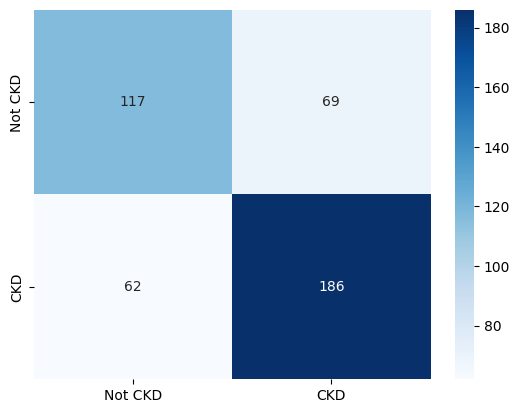

In [624]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])

In [625]:
classification_report(y_test, y_pred, target_names=['Not CKD', 'CKD'])

'              precision    recall  f1-score   support\n\n     Not CKD       0.65      0.63      0.64       186\n         CKD       0.73      0.75      0.74       248\n\n    accuracy                           0.70       434\n   macro avg       0.69      0.69      0.69       434\nweighted avg       0.70      0.70      0.70       434\n'

In [626]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

In [627]:
def predict_kidney_disease(model, scaler, features):
    features_scaled = scaler.transform([features])
    probability = model.predict(features_scaled)[0][0]
    prediction = 1 if probability > 0.5 else 0
    return prediction, probability

In [628]:
model.save('../model/kidney_disease_model.h5')
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']